In [76]:
# module import
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# path
root_path = "/content/drive/My Drive/TOY/Data Analysis/Kaggle/novel-COVID"
data_path = f"{root_path}/data"

In [27]:
# load data
df_raw = pd.read_csv(f"{data_path}/covid_19_data.csv")
df = df_raw.copy()

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53927 entries, 0 to 53926
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SNo              53927 non-null  int64  
 1   ObservationDate  53927 non-null  object 
 2   Province/State   32870 non-null  object 
 3   Country/Region   53927 non-null  object 
 4   Last Update      53927 non-null  object 
 5   Confirmed        53927 non-null  float64
 6   Deaths           53927 non-null  float64
 7   Recovered        53927 non-null  float64
dtypes: float64(3), int64(1), object(4)
memory usage: 3.3+ MB


In [29]:
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [30]:
df.tail()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
53922,53923,06/30/2020,Zacatecas,Mexico,2020-07-01 04:33:52,908.0,96.0,626.0
53923,53924,06/30/2020,Zakarpattia Oblast,Ukraine,2020-07-01 04:33:52,2889.0,91.0,943.0
53924,53925,06/30/2020,Zaporizhia Oblast,Ukraine,2020-07-01 04:33:52,572.0,17.0,418.0
53925,53926,06/30/2020,Zhejiang,Mainland China,2020-07-01 04:33:52,1269.0,1.0,1267.0
53926,53927,06/30/2020,Zhytomyr Oblast,Ukraine,2020-07-01 04:33:52,1404.0,29.0,746.0


In [31]:
# 정제
df = df.groupby(by=['ObservationDate']).sum()
df.drop(columns=['SNo'], axis=1, inplace=True)
df = df - df.shift(1) # 시계열 누적 하루 단위이므로 빼기
df = df.dropna()
df = (df - df.mean())/df.std() # 표준화
df.head()

,Confirmed,Deaths,Recovered
ObservationDate,,,
01/23/2020,-1.213310,-1.220262,-0.928623
01/24/2020,-1.209784,-1.217588,-0.928512
01/25/2020,-1.205905,-1.214532,-0.928595
01/26/2020,-1.202508,-1.215296,-0.928317
01/27/2020,-1.200114,-1.210711,-0.928428


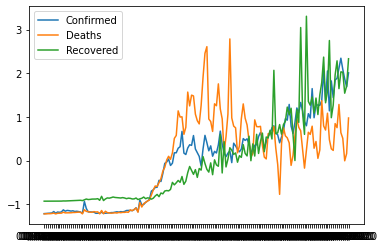

In [43]:
plt.plot(df['Confirmed'], label='Confirmed')
plt.plot(df['Deaths'], label='Deaths')
plt.plot(df['Recovered'], label='Recovered')
plt.legend()
plt.show()

# _1_. 단방향

In [46]:
df_1 = df.copy()
df_1

,Confirmed,Deaths,Recovered
ObservationDate,,,
01/23/2020,-1.213310,-1.220262,-0.928623
01/24/2020,-1.209784,-1.217588,-0.928512
01/25/2020,-1.205905,-1.214532,-0.928595
01/26/2020,-1.202508,-1.215296,-0.928317
01/27/2020,-1.200114,-1.210711,-0.928428
...,...,...,...
06/26/2020,2.343610,0.639418,2.031188
06/27/2020,2.087854,0.509530,2.022056
06/28/2020,1.870572,-0.004670,1.542642


In [47]:
df_1_arr = np.array(df_1)
df_1_arr

array([[-1.21330996e+00, -1.22026183e+00, -9.28622704e-01],
       [-1.20978357e+00, -1.21758768e+00, -9.28511677e-01],
       [-1.20590455e+00, -1.21453151e+00, -9.28594947e-01],
       [-1.20250808e+00, -1.21529555e+00, -9.28317380e-01],
       [-1.20011385e+00, -1.21071130e+00, -9.28428407e-01],
       [-1.16592644e+00, -1.20192481e+00, -9.27401408e-01],
       [-1.20423415e+00, -1.21987981e+00, -9.28150840e-01],
       [-1.17670976e+00, -1.20612704e+00, -9.28206353e-01],
       [-1.18376254e+00, -1.20459896e+00, -9.26485436e-01],
       [-1.17591169e+00, -1.20307087e+00, -9.26957300e-01],
       [-1.12698769e+00, -1.18129566e+00, -9.23459953e-01],
       [-1.15770439e+00, -1.19619449e+00, -9.24486952e-01],
       [-1.14068492e+00, -1.19543045e+00, -9.22321928e-01],
       [-1.14564043e+00, -1.19313832e+00, -9.21128388e-01],
       [-1.15607111e+00, -1.19390236e+00, -9.18602527e-01],
       [-1.14879562e+00, -1.18817204e+00, -9.14133694e-01],
       [-1.16447876e+00, -1.18740800e+00

In [55]:
df_1_arr.shape

(160, 3)

In [66]:
# ceate train data
def createTrain(data, step):
    m = np.arange(len(data) - step)

    x, y = [], []
    for i in m:
        a = data[i:(i+step)]
        x.append(a)
        b = data[i+1:(i+1+step)]
        y.append(b[-1])

    X = np.reshape(np.array(x), (len(m), step, 3))
    Y = np.reshape(np.array(y), (len(m), 3))
    
    return X, Y

In [70]:
# params
n_step = int(input('스텝 수 설정: '))
n_input = 3
n_features = 3
n_hidden = int(input('은닉 노드 수 설정: '))
n_output = 3
EPOCHS = int(input('학습 에폭 수 설정: '))
BATCH = int(input('배치 사이즈 설정: '))

스텝 수 설정: 10
은닉 노드 수 설정: 100
학습 에폭 수 설정: 300
배치 사이즈 설정: 50


In [71]:
# prepare data
X_data, Y_data = createTrain(df_1_arr, n_step)
print(f"입력 데이터 shape: {X_data.shape}, 출력 데이터 shape: {Y_data.shape}")

입력 데이터 shape: (150, 10, 3), 출력 데이터 shape: (150, 3)


In [79]:
# 모델 생성
X_input = Input(batch_shape=(None, n_step, n_features))
X_lstm = LSTM(n_hidden)(X_input)
X_output = Dense(n_output)(X_lstm)

In [80]:
# 모델 컴파일
model = Model(X_input, X_output)
print(model.summary())
model.compile(optimizer=Adam(lr=0.01), loss='mse')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 3)]           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               41600     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 41,903
Trainable params: 41,903
Non-trainable params: 0
_________________________________________________________________
None


In [82]:
# 훈련
h = model.fit(X_data, Y_data,
              batch_size=BATCH,
              epochs=EPOCHS,
              shuffle=True)

Epoch 1/300
3/3 [==============================] - 0s 9ms/step - loss: 0.5979
Epoch 2/300
3/3 [==============================] - 0s 9ms/step - loss: 0.1690
Epoch 3/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1562
Epoch 4/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1354
Epoch 5/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1191
Epoch 6/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1188
Epoch 7/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1089
Epoch 8/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1142
Epoch 9/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1054
Epoch 10/300
3/3 [==============================] - 0s 7ms/step - loss: 0.1041
Epoch 11/300
3/3 [==============================] - 0s 7ms/step - loss: 0.0982
Epoch 12/300
3/3 [==============================] - 0s 7ms/step - loss: 0.0975
Epoch 13/300
3/3 [==============================] - 0s 7ms/st

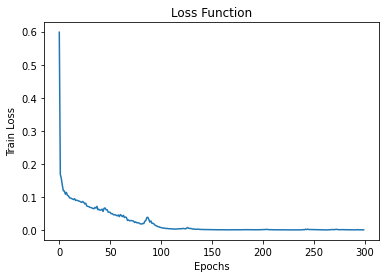

In [84]:
# plot history
plt.plot(h.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Loss Function')
plt.show()

In [85]:
# 예측
n_future = int(input('예측할 기간 설정: '))

# 마지막 100일 데이터
last_data = np.copy(X_data[-100:])

# 예측에 사용할 데이터
X_pred = np.copy(last_data)

# 예측치 저장 배열
estimates = [X_pred[-1]]

print(estimates)

예측할 기간 설정: 20
[array([[ 1.13860551,  0.47820465,  2.74847703],
       [ 1.8237271 ,  0.26923903,  0.98184483],
       [ 1.44089124,  0.23332903,  1.27095887],
       [ 1.84401312,  0.84723718,  1.95963094],
       [ 1.88530898,  0.75402399,  2.28352415],
       [ 2.11290951,  1.28503353,  1.64722902],
       [ 2.34360956,  0.63941762,  2.03118777],
       [ 2.0878536 ,  0.50953039,  2.02205581],
       [ 1.87057239, -0.00467021,  1.54264168],
       [ 1.68690323,  0.15921691,  1.70582346]])]


In [88]:
# 예측
pred_cnt = 0
for _ in range(n_future):
    x = X_pred[-n_step:].reshape(-1, n_step, 3)
    y_hat = model.predict(x)
    print(y_hat)
    break

[[ 1.8225932   0.26858848  0.9692651 ]
 [ 1.4372728   0.21540737  1.2401278 ]
 [ 1.8461845   0.82380724  1.9189091 ]
 [ 1.8964252   0.741457    2.2659593 ]
 [ 2.1410346   1.2784199   1.63046   ]
 [ 2.3480785   0.64216745  2.0007336 ]
 [ 2.1163514   0.49879953  1.9773651 ]
 [ 1.8655279  -0.00966917  1.5272633 ]
 [ 1.6816969   0.14842713  1.6693461 ]
 [ 2.0127156   0.9562253   2.2844827 ]]


In [40]:
df_test = df_raw.copy()
df_test.drop(columns=['SNo'], axis=1, inplace=True)
df_test = df_test.groupby(by=['ObservationDate']).sum()
df_test = df_test - df_test.shift(1)
df_test = df_test.dropna()
df_test

,Confirmed,Deaths,Recovered
ObservationDate,,,
01/23/2020,98.0,1.0,2.0
01/24/2020,288.0,8.0,6.0
01/25/2020,497.0,16.0,3.0
01/26/2020,680.0,14.0,13.0
01/27/2020,809.0,26.0,9.0
...,...,...,...
06/26/2020,191743.0,4869.0,106636.0
06/27/2020,177963.0,4529.0,106307.0
06/28/2020,166256.0,3183.0,89035.0


In [41]:
std_scaler = StandardScaler()
df_test[['Confirmed', 'Deaths', 'Recovered']] = std_scaler.fit_transform(df_test[['Confirmed', 'Deaths', 'Recovered']])
df_test

# dfTest[['A', 'B']] = scaler.fit_transform(dfTest[['A', 'B']])

,Confirmed,Deaths,Recovered
ObservationDate,,,
01/23/2020,-1.217119,-1.224093,-0.931538
01/24/2020,-1.213582,-1.221411,-0.931427
01/25/2020,-1.209691,-1.218345,-0.931510
01/26/2020,-1.206284,-1.219111,-0.931232
01/27/2020,-1.203882,-1.214513,-0.931343
...,...,...,...
06/26/2020,2.350968,0.641425,2.037565
06/27/2020,2.094409,0.511130,2.028405
06/28/2020,1.876445,-0.004685,1.547485


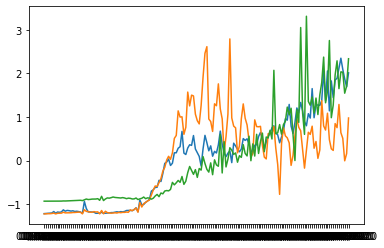

In [42]:
plt.plot(df_test['Confirmed'], label='Confirmed')
plt.plot(df_test['Deaths'], label='Deaths')
plt.plot(df_test['Recovered'], label='Recovered')
plt.show()

In [53]:
X_data, Y_data = createTrain(df_1_arr, n_step)
print(f"입력 데이터 shape: {X_data.shape}, 출력 데이터 shape: {y_data.shape}")

ValueError: ignored